In [1]:
import numpy as np
from scipy import stats

import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import cmdstanpy
import codedapertures as cappy
from functools import partial
from multiprocessing import Pool

from image_generator import gen_image
from register_to_reference import register_to_reference

/Data/Packages/Utilities/miniconda3/envs/stan_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def add_border(mask, height, width, empty=False):
    """
    Adds a border with the given width
    Parameters
    ----------
    width : int
        width of border
    """

    new_width = mask.width + width * 2
    new_height = mask.height + height * 2
    new_mask = np.zeros((new_width, new_height))

    if not empty:
        new_mask = new_mask + 1
    new_mask[width:-width, height:-height] = mask.A_ij
    mask.A_ij = new_mask

    return mask

#### Simulation parameters



In [18]:
N = 32
N_p = 10
d = N

M1 = 2 * N
M2 = 2 * (2 * N + d)

real_data, _ = gen_image(
    n_pixels=N, n_pad=1, k=2, n_disks=50, seed=0, supp_neigh=1
)

real_data /= np.linalg.norm(real_data)

In [19]:
ura = cappy.ura(rank=1, mult=2)

add_border(ura, 3, 5)
print(ura.A_ij.shape)

S = ura.A_ij

Uniformly Redundant Array
r, s: 11, 13 (rank 1)
multiplier: 2
(32, 32)


In [20]:
exper_data = np.abs(np.fft.fft2(real_data))

In [21]:
X0S = np.concatenate([real_data, np.zeros((N, d)), S], axis=1)

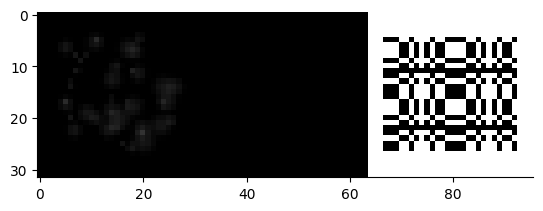

In [22]:
plt.imshow(X0S, cmap="gray")
plt.savefig("Holo_example.pdf", bbox_inches="tight")

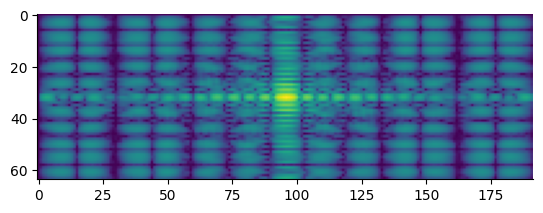

In [23]:
Y = np.abs(np.fft.fft2(X0S, s=(M1, M2))) ** 2
plt.imshow(np.fft.fftshift(np.log1p(Y)), cmap="viridis")

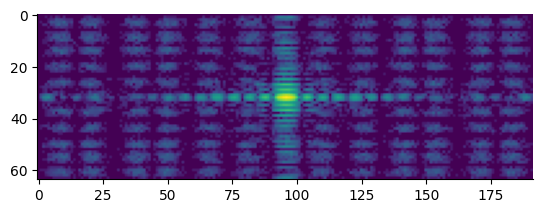

In [24]:
rate = N_p / Y.mean()
Y_tilde = stats.poisson.rvs(rate * Y, random_state=1234)
plt.imshow(np.fft.fftshift(np.log1p(Y_tilde)), cmap="viridis")

In [25]:
data = {
    "N": N,
    "d": N,
    "M1": M1,
    "M2": M2,
    "N_p": N_p,
    "Y_tilde": Y_tilde,
    "S": S,
}

In [26]:
HoloML_model = cmdstanpy.CmdStanModel(stan_file="./stan_model.stan")

In [27]:
def run_stan_error(index, data, ref_image):
    fit = HoloML_model.optimize(data)
    final_image = fit.stan_variable("X") / np.linalg.norm(fit.stan_variable("X"))
    final_image = register_to_reference(final_image, real_data)
    return np.linalg.norm(ref_image - final_image)

In [32]:
fit = HoloML_model.optimize(data)

init_image = fit.stan_variable("X")

13:24:39 - cmdstanpy - INFO - Chain [1] start processing
13:24:41 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
%%capture

with Pool() as pool:
    errors = pool.map(partial(run_stan_error, data=data, ref_image=real_data), np.linspace(0, 1, 100))

10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:16 - cmdstanpy - INFO - Chain [1] start processing
10:39:20 - cmdstanpy - INFO - Chain [1] done processing
10:39:21 - cmdstanpy - INFO - Chain [1] start processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain [1] start processing
10:39:22 - cmdstanpy - INFO - Chain [1] start processing
10:39:22 - cmdstanpy - INFO - Chain [1] start processing
10:39:22 - cmdstanpy - INFO - Chain [1] done processing
10:39:22 - cmdstanpy - INFO - Chain 

In [16]:
np.save("stan_errors_k2.npy", errors)